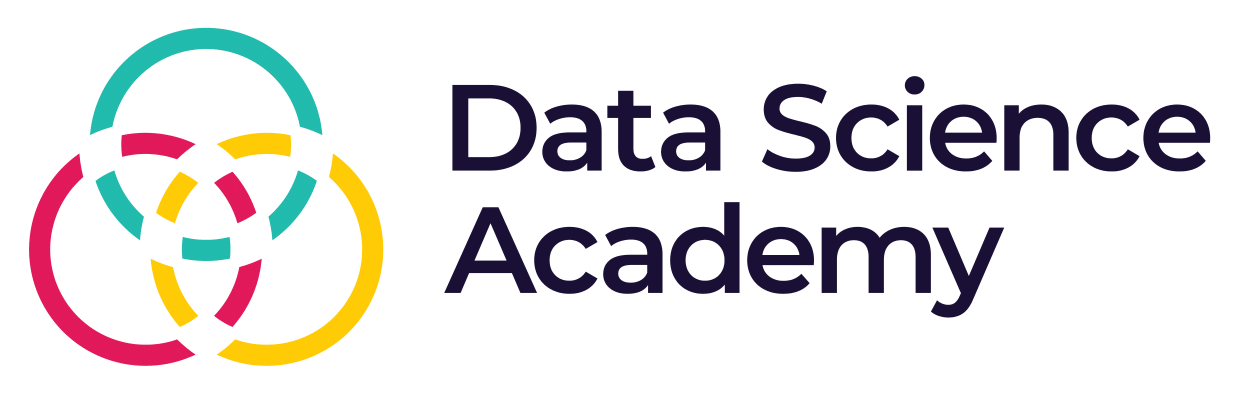

Week 8 | Case Study
=================
#### *Predicting next 7-days 2019-nCoV cumulative Confirmed, Infected, Recovered, Death cases using Linear Regression Model*

You are a Data Scientist working for the World Health Organization (WHO). Due to the outbreak of 2019-nCoV, WHO is alerted to several cases of pneumonia and wants to know how this virus will affect the population, specifically whether the Healthcare System in place is capable of addressing this issue. Therefore, you are tasked to predict the cumulative number of people affected for the next 7-days.

* __Category__: #Tabular data , #Timeseries, #Linear Regression  
* __Dataset__: Novel Corona Virus 2019 Dataset  
* __Dataset Link__: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/download

Dataset Desciption:
----------------------------
> __SNo__: *Serial Number*  
> __ObservationDate__: *Observation date in mm/dd/yyyy*  
> __Province/State__: *Province or State*  
> __Country/Region__: *Country or region*  
> __Last Update__: *Last update date time in UTC*  
> __Confirmed__: *Cumulative number of confirmed cases*  
> __Deaths__: *Cumulative number of deaths cases*  
> __Recovered__: *Cumulative number of recovered cases*  
> __*Infected__: *Confirmed - Recovered - Deaths*  


## Imports

In [1]:
import os
import sys
import re

import time
import random
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer

from matplotlib import pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
pd.options.display.max_colwidth = -1

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

RANDOM_STATE = 313
seed_everything(seed=RANDOM_STATE)

sns.set()

## Load and Explore The Dataset

In [2]:
covid = pd.read_csv('D:\\corona_data\\covid_19_data.csv')

In [3]:
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [4]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29426 entries, 0 to 29425
Data columns (total 8 columns):
SNo                29426 non-null int64
ObservationDate    29426 non-null object
Province/State     14527 non-null object
Country/Region     29426 non-null object
Last Update        29426 non-null object
Confirmed          29426 non-null float64
Deaths             29426 non-null float64
Recovered          29426 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.8+ MB


In [5]:
covid.describe(include="all")

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
count,29426.000000,29426,14527,29426,29426,29426.000000,29426.000000,29426.000000
unique,NaN,125,429,223,1866,NaN,NaN,NaN
top,NaN,05/24/2020,Diamond Princess cruise ship,US,3/8/20 5:31,NaN,NaN,NaN
freq,NaN,452,187,5338,1232,NaN,NaN,NaN
mean,14713.500000,NaN,NaN,NaN,NaN,6237.239754,408.005573,2003.861755
std,8494.698847,NaN,NaN,NaN,NaN,24551.983717,2289.689879,12326.847623
min,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,7357.250000,NaN,NaN,NaN,NaN,20.000000,0.000000,0.000000
50%,14713.500000,NaN,NaN,NaN,NaN,252.000000,3.000000,10.000000
75%,22069.750000,NaN,NaN,NaN,NaN,1642.750000,42.000000,251.750000


In [6]:
covid.dtypes

SNo                int64  
ObservationDate    object 
Province/State     object 
Country/Region     object 
Last Update        object 
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

## Preprocessing

In [7]:
# Check for nulls
covid.isnull().sum()

SNo                0    
ObservationDate    0    
Province/State     14899
Country/Region     0    
Last Update        0    
Confirmed          0    
Deaths             0    
Recovered          0    
dtype: int64

In [8]:
# Handle column names
cols = covid.columns
covid.columns = [col.lower() for col in cols]

covid.rename(columns={'observationdate' : 'observation_date', 
                      'country/region' : 'country',
                      'province/state' : 'province',
                      'last update' : 'last_update'}, inplace=True)

covid.head()

,sno,observation_date,province,country,last_update,confirmed,deaths,recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [9]:
sorted(covid.country.unique())

[' Azerbaijan',
 "('St. Martin',)",
 'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Channel Islands',
 'Chile',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faroe Islands',
 'Fiji',
 'Finland',
 

In [10]:
# Handle country names
def clean_country(country):
    country = country.lower().strip()
    country = re.sub(r'[^a-z\s]+', '', country)
    country = 'China' if country == 'Mainland China' else country
    return country

covid['country'] = covid['country'].apply(lambda country: clean_country(country))

In [11]:
sorted(covid.country.unique())

['afghanistan',
 'albania',
 'algeria',
 'andorra',
 'angola',
 'antigua and barbuda',
 'argentina',
 'armenia',
 'aruba',
 'australia',
 'austria',
 'azerbaijan',
 'bahamas',
 'bahamas the',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bhutan',
 'bolivia',
 'bosnia and herzegovina',
 'botswana',
 'brazil',
 'brunei',
 'bulgaria',
 'burkina faso',
 'burma',
 'burundi',
 'cabo verde',
 'cambodia',
 'cameroon',
 'canada',
 'cape verde',
 'cayman islands',
 'central african republic',
 'chad',
 'channel islands',
 'chile',
 'colombia',
 'comoros',
 'congo brazzaville',
 'congo kinshasa',
 'costa rica',
 'croatia',
 'cuba',
 'curacao',
 'cyprus',
 'czech republic',
 'denmark',
 'diamond princess',
 'djibouti',
 'dominica',
 'dominican republic',
 'east timor',
 'ecuador',
 'egypt',
 'el salvador',
 'equatorial guinea',
 'eritrea',
 'estonia',
 'eswatini',
 'ethiopia',
 'faroe islands',
 'fiji',
 'finland',
 'france',
 'french guiana',
 'gabon',
 'g

In [12]:
# Check if the number of cases per country increases monotonically as time passes by, if not, fix it
def check_monotonic_increasing(grp):
    if np.sum(np.diff(grp) < 0) > 0:
        return False
    else:
        return True
    
def force_monotonic_increasing(grp):
    if np.sum(np.diff(grp) < 0) > 0:
        return sorted(grp)
    else:
        return grp

In [13]:
group_country_date = covid.groupby(by=['country', 'observation_date']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'}).sort_values(by=['country', 'observation_date'], ascending=[True, True])
group_country = group_country_date.reset_index(level=1, drop=True)
country_date_scores = group_country_date.reset_index()
country_scores = group_country.reset_index()

In [14]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: check_monotonic_increasing(grp))
monitor = monitor.apply(lambda x: x['confirmed'] and x['deaths'] and x['recovered'], axis=1)
non_monotonic_increase = country_scores.iloc[np.where(monitor == False)]
print(non_monotonic_increase.country.unique())
non_monotonic_increase

['algeria' 'andorra' 'australia' 'austria' 'azerbaijan' 'bahamas'
 'bahrain' 'belarus' 'belgium' 'benin' 'cambodia' 'cameroon' 'canada'
 'cyprus' 'czech republic' 'denmark' 'ecuador' 'egypt' 'estonia'
 'ethiopia' 'finland' 'france' 'germany' 'ghana' 'greenland' 'guam'
 'guernsey' 'guyana' 'haiti' 'honduras' 'hong kong' 'iceland' 'india'
 'iraq' 'ireland' 'italy' 'japan' 'jersey' 'kazakhstan' 'laos' 'latvia'
 'lebanon' 'libya' 'lithuania' 'luxembourg' 'madagascar' 'mainland china'
 'malta' 'mauritius' 'montenegro' 'nepal' 'netherlands' 'new zealand'
 'occupied palestinian territory' 'others' 'philippines' 'poland'
 'portugal' 'puerto rico' 'republic of the congo' 'russia'
 'saint barthelemy' 'san marino' 'serbia' 'slovakia' 'south korea' 'spain'
 'sri lanka' 'tajikistan' 'the bahamas' 'the gambia' 'togo'
 'trinidad and tobago' 'uganda' 'uk' 'uruguay' 'us' 'venezuela' 'vietnam'
 'west bank and gaza' 'yemen' 'zimbabwe']


,country,confirmed,deaths,recovered
170,algeria,1.0,0.0,0.0
171,algeria,1.0,0.0,0.0
172,algeria,1.0,0.0,0.0
173,algeria,1.0,0.0,0.0
174,algeria,1.0,0.0,0.0
175,algeria,1.0,0.0,0.0
176,algeria,3.0,0.0,0.0
177,algeria,5.0,0.0,0.0
178,algeria,12.0,0.0,0.0
179,algeria,12.0,0.0,0.0


In [15]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: force_monotonic_increasing(grp))
country_scores[monitor.columns] = monitor.values

In [16]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: check_monotonic_increasing(grp))
monitor = monitor.apply(lambda x: x['confirmed'] and x['deaths'] and x['recovered'], axis=1)
non_monotonic_increase = country_scores.iloc[np.where(monitor == False)]
print(non_monotonic_increase.country.unique())

[]


In [17]:
country_date_scores[country_scores.columns] = country_scores.values

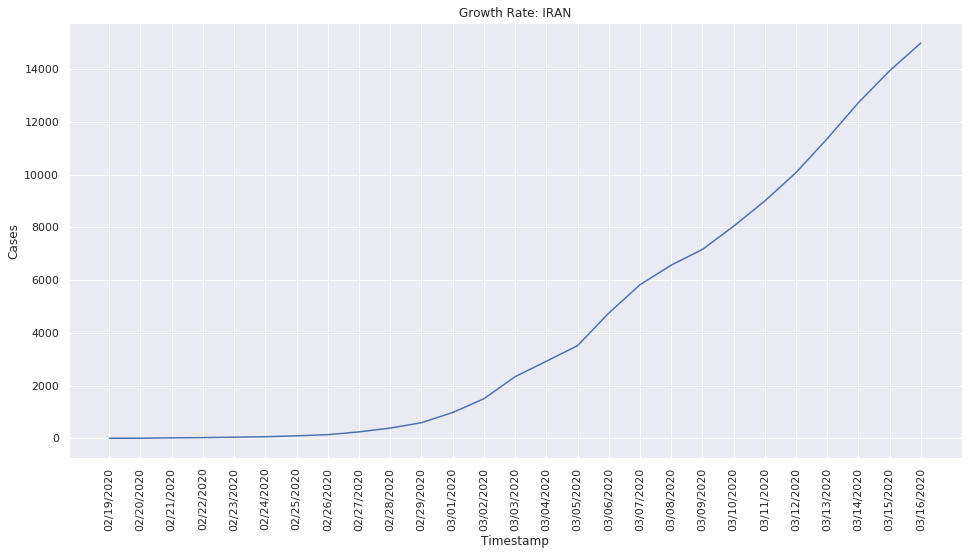

In [18]:
# Plot growth rate for an Area of Interest
area_of_interest = 'iran'
y_data = country_date_scores.loc[country_date_scores.country == area_of_interest, 'confirmed']
x_data = country_date_scores.loc[country_date_scores.country == area_of_interest, 'observation_date']

plt.subplots(1, 1, figsize=(16, 8))
plt.plot(x_data, y_data)
plt.xlabel("Timestamp")
plt.ylabel("Cases")
plt.title(f"Growth Rate: {area_of_interest.upper()}")
plt.xticks(rotation=90)
plt.show()

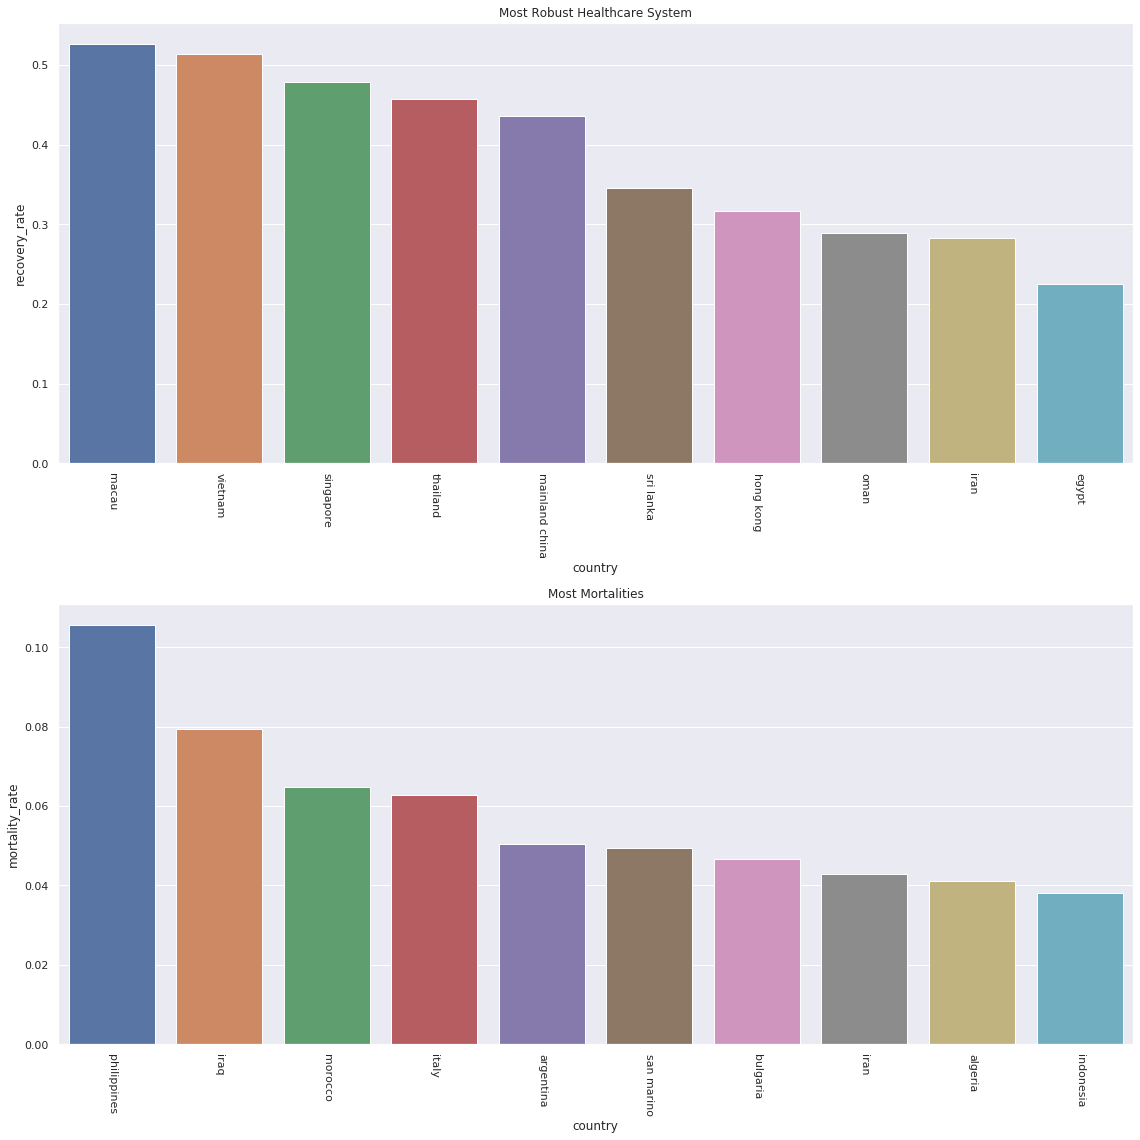

In [19]:
# Most robust healthcare system
# Most mortalities
# There is an issue here, find it

group_country_scores = country_scores.groupby(by=['country']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'})
group_country_scores['recovery_rate'] = group_country_scores['recovered'] / group_country_scores['confirmed']
group_country_scores['mortality_rate'] = group_country_scores['deaths'] / group_country_scores['confirmed']

fig, axes = plt.subplots(2, 1, figsize=(16, 16))

recovery_df = group_country_scores.loc[group_country_scores['confirmed'] > 100, ['recovery_rate']].sort_values(by=['recovery_rate'], ascending=False).head(10)
sns.barplot(x=recovery_df.index, y="recovery_rate", data=recovery_df, ax=axes[0])
axes[0].set_title("Most Robust Healthcare System")
axes[0].xaxis.set_tick_params(rotation=270)

mortality_df = group_country_scores.loc[group_country_scores['confirmed'] > 100, ['mortality_rate']].sort_values(by=['mortality_rate'], ascending=False).head(10)
sns.barplot(x=mortality_df.index, y="mortality_rate", data=mortality_df, ax=axes[1])
axes[1].set_title("Most Mortalities")
axes[1].xaxis.set_tick_params(rotation=270)

fig.tight_layout()
plt.show()

In [20]:
# Check if confirmed cases are greater or equal to the sum of death and recovered cases combined
country_date_scores['check_sum'] = country_date_scores.apply(lambda x: True if x['confirmed'] >= (x['deaths'] + x['recovered']) else False, axis=1)
print(np.sum(~country_date_scores['check_sum']))
country_date_scores.drop(['check_sum'], axis=1, inplace=True)

0


In [21]:
# Convert observation_date to pandas datetime format for further processing
# country_date_scores['observation_date'] = pd.to_datetime(country_date_scores['observation_date'])
country_date_scores['observation_date'] = country_date_scores['observation_date'].map(pd.to_datetime)

In [22]:
date_scores = country_date_scores.groupby(by=['observation_date']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'}).reset_index()

In [23]:
# Calculate days_since
date_scores['days_since'] = (date_scores['observation_date'] - date_scores['observation_date'].min()).dt.days

In [24]:
# Check if days_since increases monotonically
assert np.sum(np.diff(date_scores['days_since']) < 0) == 0

In [25]:
# Check if there exists a gap in days_since
last_day = date_scores.iloc[-1]['days_since']
assert date_scores['days_since'].sum() == 0.5 * last_day * (last_day + 1)

In [26]:
# Calculate infected/active cases
date_scores['infected'] = date_scores['confirmed'] - (date_scores['recovered'] + date_scores['deaths'])

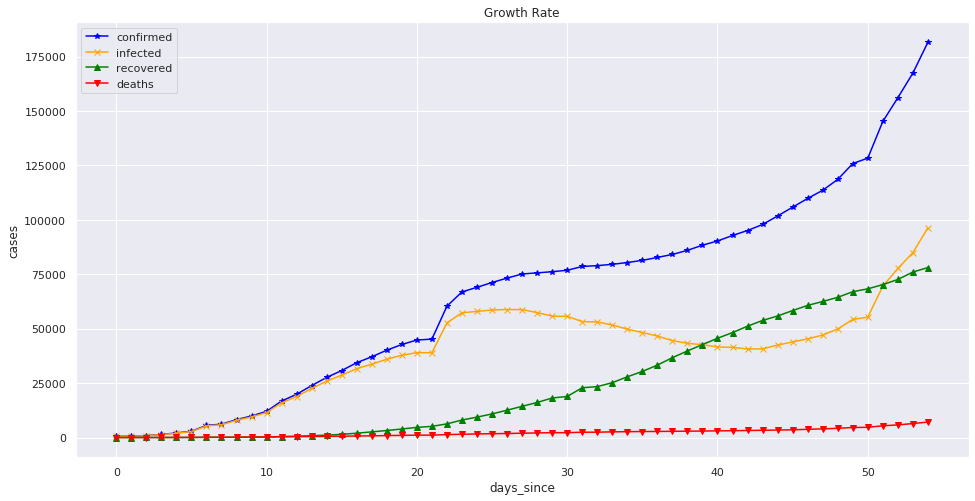

In [27]:
plt.subplots(1, 1, figsize=(16, 8))
plt.plot(date_scores['days_since'], date_scores['confirmed'], label='confirmed', marker='*', color='blue')
plt.plot(date_scores['days_since'], date_scores['infected'], label='infected', marker='x', color='orange')
plt.plot(date_scores['days_since'], date_scores['recovered'], label='recovered', marker='^', color='green')
plt.plot(date_scores['days_since'], date_scores['deaths'], label='deaths', marker='v', color='red')
plt.xlabel("days_since")
plt.ylabel("cases")
plt.title("Growth Rate")
plt.legend(loc='upper left')

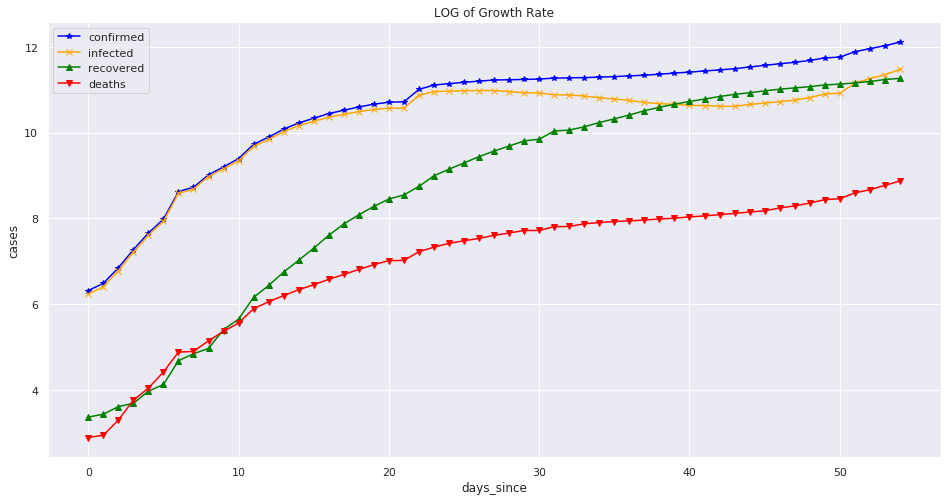

In [28]:
# Better idea?
# Linearization of curves may help to get better performance over the exponential segment
# If you are doing this, make sure that you also inverse the log function when predicting
plt.subplots(1, 1, figsize=(16, 8))
plt.plot(date_scores['days_since'], np.log1p(date_scores['confirmed']), label='confirmed', marker='*', color='blue')
plt.plot(date_scores['days_since'], np.log1p(date_scores['infected']), label='infected', marker='x', color='orange')
plt.plot(date_scores['days_since'], np.log1p(date_scores['recovered']), label='recovered', marker='^', color='green')
plt.plot(date_scores['days_since'], np.log1p(date_scores['deaths']), label='deaths', marker='v', color='red')
plt.xlabel("days_since")
plt.ylabel("cases")
plt.title("LOG of Growth Rate")
plt.legend(loc='upper left')

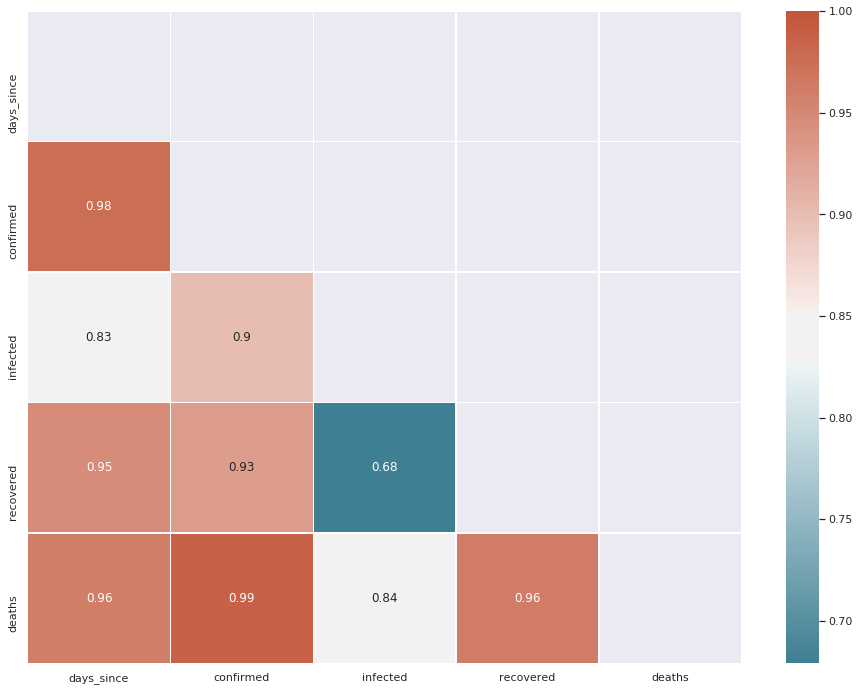

In [29]:
# Correlations

# Set up figure
fig, ax = plt.subplots(figsize=(16, 12))

# Create correlation dataframe
df_corr = date_scores[['days_since', 'confirmed', 'infected', 'recovered', 'deaths']]

# Create correlation matrix
corr = df_corr.corr()

# # Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# Plot correlation matrix without the diagonal and upper part
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, linewidths=.5)

Modeling
========

In [30]:
date_scores.head()

,observation_date,confirmed,deaths,recovered,days_since,infected
0,2020-01-22,554.0,17.0,28.0,0,509.0
1,2020-01-23,654.0,18.0,30.0,1,606.0
2,2020-01-24,941.0,26.0,36.0,2,879.0
3,2020-01-25,1438.0,42.0,39.0,3,1357.0
4,2020-01-26,2118.0,56.0,52.0,4,2010.0


In [31]:
# Train/Test Split

# train + validation interval: '2020-01-22':'2020-03-09'
# test interval:  '2020-03-10':'2020-03-16'

X_columns = ['days_since']

# Change y_column to one of ('confirmed', 'infected', 'recovered', 'deaths')
# and re-run this cell and cells below
y_column = ['confirmed'] 
    
X_train = date_scores.loc[date_scores['observation_date'] < '2020-03-10', X_columns]
X_test = date_scores.loc[date_scores['observation_date'] >= '2020-03-10', X_columns]
y_train = date_scores.loc[date_scores['observation_date'] < '2020-03-10', y_column]
y_test = date_scores.loc[date_scores['observation_date'] >= '2020-03-10', y_column]

In [32]:
# Linear Regression i.e. ElasticNet
enet = ElasticNet(random_state=RANDOM_STATE, normalize=True)
parameters = {'alpha':[1.5, 1.0, 0.75, 0.5], 'l1_ratio':[0, 0.3, 0.5, 0.7, 1.0]}
regressor = GridSearchCV(estimator=enet, 
                         param_grid=parameters, 
                         cv=[(slice(0, 35), slice(35, 48))],
                         scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False), 
                                  "mae": make_scorer(mean_absolute_error, greater_is_better=False), 
                                  "r2": make_scorer(r2_score, greater_is_better=True)},
                         refit="mse",
                         return_train_score=True)

regressor.fit(X_train, y_train)

GridSearchCV(cv=[(slice(0, 35, None), slice(35, 48, None))], error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=313, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1.5, 1.0, 0.75, 0.5],
                         'l1_ratio': [0, 0.3, 0.5, 0.7, 1.0]},
             pre_dispatch='2*n_jobs', refit='mse', return_train_score=True,
             scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False),
                      'mse': make_scorer(mean_squared_error, greater_is_better=False),
                      'r2': make_scorer(r2_score)},
             verbose=0)

In [33]:
cv_results = regressor.cv_results_
cv_results

{'mean_fit_time': array([0.00271773, 0.00330472, 0.00254965, 0.00455189, 0.00233293,
        0.00226235, 0.00206971, 0.00199294, 0.00235105, 0.00202298,
        0.00213051, 0.00195503, 0.0020535 , 0.00195026, 0.00198221,
        0.00218487, 0.00211143, 0.00195909, 0.00193   , 0.00207996]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'mean_score_time': array([0.00630689, 0.00462341, 0.00307369, 0.00398421, 0.00282717,
        0.00294042, 0.00259423, 0.00252628, 0.00253844, 0.00261593,
        0.00250721, 0.00249577, 0.00268698, 0.00261402, 0.00247526,
        0.0024755 , 0.00259757, 0.00248122, 0.00247359, 0.00257874]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'param_alpha': masked_array(data=[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75,
                    0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5],
              mask=[False

In [34]:
regressor.best_estimator_

ElasticNet(alpha=1.5, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=313, selection='cyclic', tol=0.0001, warm_start=False)

In [35]:
test_scores = pd.DataFrame()
test_scores['y_true'] = y_test.values.flatten()
test_scores['y_pred'] = regressor.predict(X_test).flatten()
test_scores

,y_true,y_pred
0,118575.0,116479.734486
1,125868.0,119018.017867
2,128352.0,121556.301247
3,145208.0,124094.584627
4,156109.0,126632.868008
5,167424.0,129171.151388
6,181614.0,131709.434769


Results
========

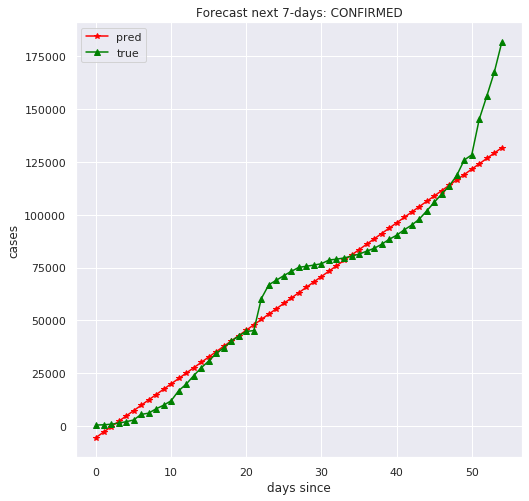

Scores:
------- 

Train MSE: 29924089.090712283
Train MAE: 4717.459881027738
Train R2: 0.9661250954810194


Val MSE: 203098346.8102299
Val MAE: 14121.218607347195
Val R2: 0.9682775259718077


Test MSE: 766551234.015707
Test MAE: 22069.701086863846
Test MAPE: 13.75 %
Test R2: -0.6265821727178642


In [36]:
results = pd.DataFrame()
results['y_pred'] = regressor.predict(date_scores[X_columns])
results['y_true'] = date_scores[y_column]

plt.subplots(1, 1, figsize=(8, 8))
plt.plot(results['y_pred'], marker='*', color='red', label="pred")
plt.plot(results['y_true'], marker='^', color='green', label="true")
plt.xlabel("days since")
plt.ylabel("cases")
plt.title(f"Forecast next 7-days: {y_column[0].upper()}")
plt.legend()
plt.show()

best_score_index = np.where(cv_results['rank_test_mse'] == cv_results['rank_test_mse'].min())[0].item()

print("Scores:")
print("-"*7, "\n")
print(f"Train MSE: {np.abs(cv_results['mean_train_mse'][best_score_index])}") 
print(f"Train MAE: {np.abs(cv_results['mean_train_mae'][best_score_index])}")
print(f"Train R2: {np.abs(cv_results['mean_train_r2'][best_score_index])}")
print('\n')
print(f"Val MSE: {np.abs(cv_results['mean_test_mse'][best_score_index])}") 
print(f"Val MAE: {np.abs(cv_results['mean_test_mae'][best_score_index])}")
print(f"Val R2: {np.abs(cv_results['mean_test_r2'][best_score_index])}")
print('\n')
print(f"Test MSE: {mean_squared_error(test_scores['y_true'], test_scores['y_pred'])}")
print(f"Test MAE: {mean_absolute_error(test_scores['y_true'], test_scores['y_pred'])}")
print(f"Test MAPE: {np.around(np.mean(np.abs(test_scores['y_true'] - test_scores['y_pred'])/test_scores['y_true'])*100.0, 2)} %")
print(f"Test R2: {r2_score(test_scores['y_true'], test_scores['y_pred'])}")

Conclusion
===========

Linear Regression will undergo performance degradation when underlying relationships between the predictor and target variables are not linear. Therefore, linear models can only be a very coarse estimate of the reality. For more sophisticated predictions on complex data non-linear models e.g. RandomForest, XGBoost, LightGBM, CatBoost, Neural Networks, non-linear SVM etc. can be utilized. Ensemble of well-performing models (stacking/blending) with smart cross-validation strategy is expected to further increase the score.